# Homework #7 
Josh Cohen

In [1]:
import numpy as np
import sympy as sym
%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, trapz
# from scipy.optimize import minimize

## Problem 1
Create a function that calculates the directional derivative of a Q,R,P1 style cost function for any given trajectory and perturbation with $x_d(t)$ as desired trajectory
Evaluate the directional derivative along inital traj. with perturbation $v_1(t) = 0.05sin(t)-0.1$, $v_2(t)= 0.05cos(t)$

In [2]:
Q = sym.Matrix([[1000, 0, 0],[0, 1000, 0], [0,0,1]])
R = sym.Matrix([[100, 0],[0,1]])
P1 = sym.Matrix([[1000, 0, 0],[0, 1000, 0],[0, 0, 100]])

In [3]:
T= 2 * np.pi
t = sym.symbols('t')

x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)
x2 = sym.Function('x_2')(t)

z0 = sym.Function('z_0')(t)
z1 = sym.Function('z_1')(t)
z2 = sym.Function('z_2')(t)

x = sym.Matrix([x0, x1, x2])
z = sym.Matrix([z0, z1, z2])

x_fin = sym.MatrixSymbol('x(T)', 3, 1).as_explicit()
z_fin = sym.MatrixSymbol('z(T)', 3, 1).as_explicit()
x_init = np.array([0,0,np.pi/2])
z_init = np.zeros(3)

x_d = sym.Matrix([4/(2*sym.pi) * t, 0, sym.pi/2])
x_d_fin = x_d.subs(t, T)

u0 = sym.Function('u_0')(t)
u1 = sym.Function('u_1')(t)
v0 = sym.Function('v_0')(t)
v1 = sym.Function('v_1')(t)

u = sym.Matrix([u0,u1])
v = sym.Matrix([v0,v1])
u_init = np.array([1,-1/2])

xdot = sym.Matrix([sym.cos(x[2])*u[0], sym.sin(x[2]) * u[0], u[1]])

A = xdot.jacobian(x)
B = xdot.jacobian(u)

In [4]:
def get_v():
    v = sym.Matrix([-0.5 * sym.sin(t) - 0.1, 0.5*sym.cos(t)])
#     v = sym.Matrix([ 0.05*sym.cos(t),0.05 * sym.sin(t) - 0.1])
    
    return v

In [5]:
#args:
#    x_init - intitial x,y,theta Nx1
#    x_d_traj - desired trajectory Nx1xD
#    u_traj - effort Nx1xD
#    t_vec - time vector 1xD
#    get_v - function that returns symbolic v 


def compute_dd_for_perturb(x_init,x_d_traj,u_traj,t_vec,get_v):
    v = get_v()
    u_init = u_traj[:,0]
    zdot = A * z + B * v
    
    q = sym.Matrix([z, x])
    qdot = sym.Matrix([zdot, xdot]).subs({u[0]:u_init[0], u[1]:u_init[1]})
#     display(qdot)
    q_init = np.concatenate((z_init, x_init))
    
    qdot_lam = sym.lambdify([t, q], sym.flatten(qdot))
    ans = solve_ivp(qdot_lam, (0, T), q_init, t_eval=t_vec)

    zed = ans.y[:3,:]
    x_traj = ans.y[3:,:]
    t_vec = ans.t
    v_lam = sym.lambdify(t,v)
    ved = np.squeeze(v_lam(t_vec))
    
    J_dd_integrand = np.zeros(t_vec.shape[0])
    for i in range(t_vec.shape[0]):
        J_dd_integrand[i] = np.matmul(np.matmul((x_traj[:,i] - x_d_traj[:,i]).T, Q), zed[:,i]) \
                                        + np.matmul(np.matmul(u_traj[:,i].T, R), ved[:,i])
    
    J_dd_term = np.matmul(np.matmul((x_traj[:,-1] - x_d_traj[:,-1]).T, P1), zed[:,-1])

    J_dd_val = trapz(J_dd_integrand, t_vec) + J_dd_term
    
    return J_dd_val, zed, x_traj

In [6]:
t_vec = np.linspace(0,T,1000)
x_to_dd = np.repeat(np.expand_dims(x_init,1), t_vec.shape[0], axis=1)
u_to_dd = np.repeat(np.expand_dims(u_init,1), t_vec.shape[0], axis=1)

x_0_d_gen = sym.lambdify([t], x_d[0])
x_0_d = np.expand_dims(x_0_d_gen(t_vec),0)
x_12 = np.array([[0,np.pi/2]]).T
x_12_d = np.repeat(x_12, t_vec.shape[0], axis=1)
x_d_to_dd = np.concatenate((x_0_d, x_12_d))

x_d_traj = x_d_to_dd
u_traj = u_to_dd
# qdot = sym.Matrix([zdot, xdot])
# q_init = np.concatenate((z_init, x_init))

In [7]:
J_dd, zed, xed = compute_dd_for_perturb(x_init, x_d_to_dd, u_to_dd, t_vec, get_v)
J_dd

-4248.40865525442

### Ans:
$DJ \zeta=-4248.40865525442$

<IPython.core.display.Javascript object>


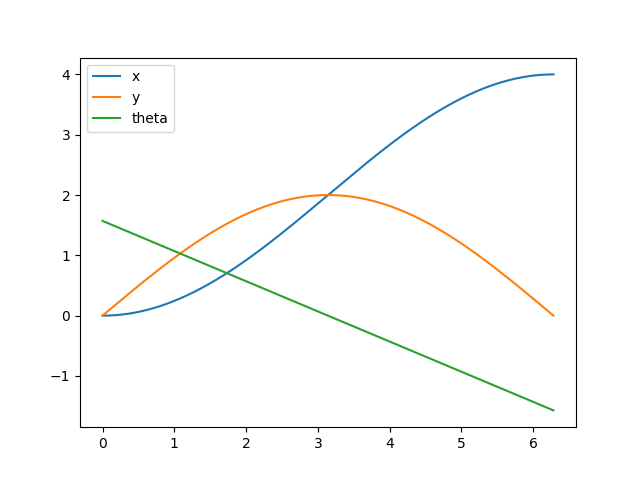

In [8]:
plt.figure()
plt.plot(t_vec, xed[0,:])
plt.plot(t_vec, xed[1,:])
plt.plot(t_vec, xed[2,:])
plt.legend(["x", "y", "theta"])
plt.show()

<IPython.core.display.Javascript object>


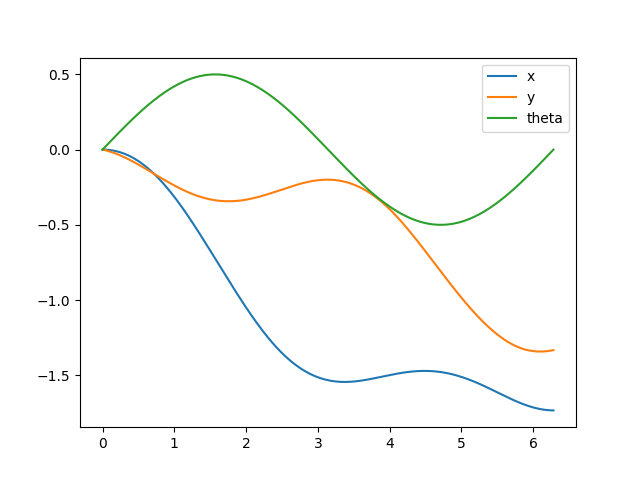

In [9]:
plt.figure()
plt.plot(t_vec, zed[0,:])
plt.plot(t_vec, zed[1,:])
plt.plot(t_vec, zed[2,:])
plt.legend(["x", "y", "theta"])
plt.show()

## Problem #2
Create a function that performs the Armijo line search for the diff drive vehichle. Determine optimal step size for the descent direction defined by $v_1(t), v_2(t)$ and the inital semi circle traj defined by $u_1(t) = 1, u_2(t)=\frac{-1}{2}$. 

In [10]:
J_integrand = (x - x_d).T * Q * (x - x_d) + u.T * R * u
J_int_lam = sym.lambdify([t, x, u], sym.flatten(J_integrand))
def J(psi, x_d=x_d_traj, t_span=t_vec):
    x = psi[:3,:]
    u = psi[3:,:]
    N = t_span.shape[0]
    J_int = np.zeros(N)
    for i,t in zip(range(N),t_span):
        J_int[i] = J_int_lam(t, x[:,i], u[:,i])[0]
        
    J_term = np.matmul(np.matmul((x[:,-1] - x_d[:,-1]).T, P1), (x[:,-1] - x_d[:,-1]))
    J_val = 0.5 * trapz(J_int, t_span) + 0.5 * J_term
    
    return float(J_val)

In [11]:
def J_dd_z(psi,zeta, x_d_traj=x_d_traj,t_vec=t_vec):
    x_traj = psi[:3,:]
    u_traj = psi[3:,:]
    zed = zeta[:3,:]
    ved = zeta[3:,:]
    
    J_dd_integrand = np.zeros(t_vec.shape[0])
    for i in range(t_vec.shape[0]):
        J_dd_integrand[i] = np.matmul(np.matmul((x_traj[:,i] - x_d_traj[:,i]).T, Q), zed[:,i]) \
                                        + np.matmul(np.matmul(u_traj[:,i].T, R), ved[:,i])
    
    J_dd_term = np.matmul(np.matmul((x_traj[:,-1] - x_d_traj[:,-1]).T, P1), zed[:,-1])

    J_dd_val = trapz(J_dd_integrand, t_vec) + J_dd_term
    
    return float(J_dd_val)

In [12]:
alpha = 0.4
beta = 0.7 
eps = 0.05
iter_count = 0
# vals = np.zeros(t_vec.shape[0])
# vals[iter_count] = J(x_i)

In [13]:
n = 0
gam = beta**n
x_i = np.vstack((xed,u_traj))
ved = np.squeeze(sym.lambdify(t, get_v())(t_vec))
z_i = np.vstack((zed,ved))
# np.linalg.norm(J(x_i + gam * z_i))

In [14]:
def suff_compare(x_i, z_i, gam, alpha=alpha):
    return J(x_i) + alpha * gam * J_dd_z(x_i,z_i)

<IPython.core.display.Javascript object>


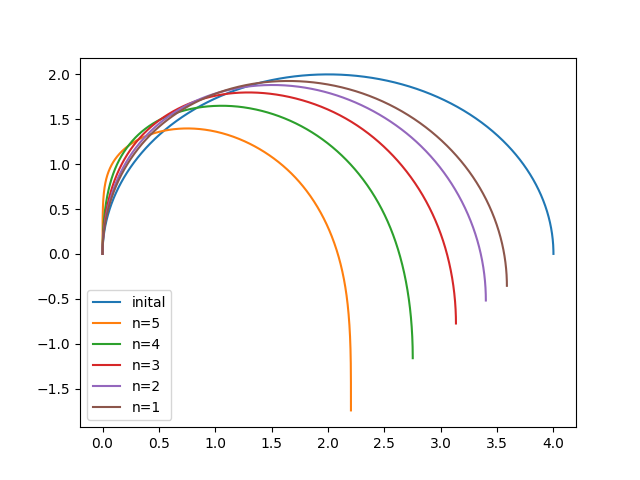

0.16806999999999994


In [15]:
n = 0
gam = beta**n
psi = sym.Matrix([x,u])
x_i = np.vstack((xed,u_traj))
z_i = np.vstack((zed,ved))
plt.figure()
x_i_old = x_i
leg = []
plt.plot(x_i[0,:],x_i[1,:])

while np.linalg.norm(J(x_i + gam * z_i)) > np.linalg.norm(suff_compare(x_i_old, z_i, gam)):
    ued = u_init.reshape(2,1) + gam * get_v()
    udot = ued.diff(t)
    psidot = sym.lambdify([t, psi], sym.flatten(sym.Matrix([xdot,udot])))
    psi_init = np.concatenate((x_init, np.squeeze(ued.subs(t,0))))
    x_i = solve_ivp(psidot, (0, T), psi_init, t_eval=t_vec).y
    plt.plot(x_i[0,:],x_i[1,:])
    n += 1
    
#     print(J(x_i))
#     print(J(x))
    
    leg.append("n={}".format(n))
    gam = beta**n

plt.legend(["inital"] + leg[::-1])
plt.show()
print(gam)

<IPython.core.display.Javascript object>


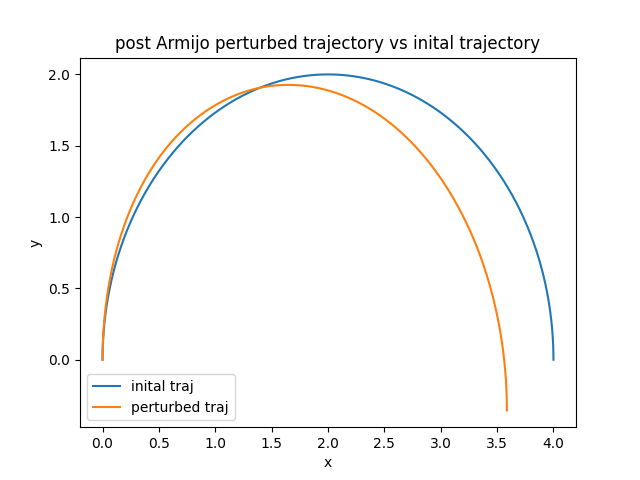

In [16]:
plt.figure()
plt.plot(x_i_old[0,:], x_i_old[1,:])
plt.plot(x_i[0,:], x_i[1,:])
plt.legend(["inital traj", "perturbed traj"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("post Armijo perturbed trajectory vs inital trajectory")
plt.show()

## Problem 3
Apply iLQR to the diff drive vehichle. Turn in a plot of the optimal traj & initial traj, a plot of control signals, and tuned values for $Q,R,P_1$


In [17]:
# l = sym.Matrix([(x - x_d).T * Q * (x-x_d) + u.T * R * u])
m = (x - x_d).T * P1 * (x - x_d)

P_0 = sym.Function("P_0")(t)
P_1 = sym.Function("P_1")(t)
P_2 = sym.Function("P_2")(t)
P_3 = sym.Function("P_3")(t)
P_4 = sym.Function("P_4")(t)
P_5 = sym.Function("P_5")(t)
P_6 = sym.Function("P_6")(t)
P_7 = sym.Function("P_7")(t)
P_8 = sym.Function("P_8")(t)
r0 = sym.Function("r_0")(t)
r1 = sym.Function("r_1")(t)
r2 = sym.Function("r_2")(t)
r = sym.Matrix([r0, r1, r2])
P = sym.Matrix([[P_0, P_1, P_2],[P_3,P_4,P_5], [P_6,P_7,P_8]])

v0 = sym.Function('v_0')(t)
v1 = sym.Function('v_1')(t)
v = sym.Matrix([v0,v1])

psi = sym.Matrix([x,u])

In [18]:
#for some reason taking ab = l.jacobian(psi) breaks sympy lambdify
a = Q * (x - x_d)
b = R * u

In [19]:
v_sym = -R.inv() * B.T * P * z - R.inv() * B.T * r - R.inv() * b

In [20]:
Pdot = -P * A - A.T * P + P*B*R.inv()*B.T*P - Q
Pfin = np.array(P1)
rdot = -(A - B *R.inv()*B.T*P).T * r - a + P*B*R.inv()*b
rfin = m.jacobian(x).T  
rfin_lam = sym.lambdify([t, psi], rfin)

In [21]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [22]:
xdot_lam = sym.lambdify([t, x, u],sym.flatten(xdot))

def xdirt(t, x, u=u_traj):
    t_idx = find_nearest(t_vec, t)
    x_ret = xdot_lam(t, x, u[:,t_idx])
    return x_ret

In [23]:
ans_x = solve_ivp(xdirt,(0,T),x_init,t_eval=t_vec)
x_t = ans_x.y
u_t = u_traj
x_i = np.vstack((x_t,u_t))

In [24]:
q_Pr = sym.Matrix([P.reshape(9,1), r])
r_fin_eval = np.squeeze(rfin_lam(T, x_i[:,-1]))
q_Pr_fin = np.concatenate([Pfin.flatten(), r_fin_eval])
q_Pr_dot = sym.Matrix([Pdot.reshape(9,1), rdot])
q_Pr_dot_lam = sym.lambdify([t,q_Pr,psi], q_Pr_dot)

def Pr_dirt(t, q_Pr, x_i=x_i):
    t_index = find_nearest(t_vec, t) 
    ret_val = q_Pr_dot_lam(t, q_Pr, x_i[:,t_index])

    return ret_val.flatten()

In [25]:
ans_Pr = solve_ivp(Pr_dirt, (T,0) ,q_Pr_fin, t_eval=np.flip(t_vec), args=(np.array([x_i])))

In [26]:
#flip to get numerical P and r from (0,T)
P_t = np.flip(ans_Pr.y[:9,:], axis=-1)
r_t = np.flip(ans_Pr.y[9:12,:],axis=-1)

In [27]:
zdot = A*z + B * v_sym
zdot_lam = sym.lambdify([t, z, P.reshape(9,1), r, psi], zdot)
def z_dirt(t, z, P=P_t, r=r_t, psi=x_i):
    t_index = find_nearest(t_vec, t) 
    z_ret = zdot_lam(t, z, P[:,t_index], r[:,t_index], psi[:,t_index])
    return z_ret.flatten()

# zdot_lam(t, z_init, P_t[:,0], r_t[:,0], psi_init)

In [28]:
ans_z = solve_ivp(z_dirt, (0,T), z_init, t_eval=t_vec, args=(P_t, r_t, x_i))

In [29]:
z_t = ans_z.y

In [30]:
v_lam = sym.lambdify([t, P.reshape(9,1), r, psi, z],v_sym)
v_t = v_lam(0, P_t, r_t, x_i, z_t).reshape(2,-1)

In [31]:
z_i = np.vstack((z_t,v_t))

In [32]:
np.linalg.norm(z_i)

164.15194628771192

In [33]:
alpha = 0.4
beta = 0.7 
eps = 0.05
n = 0
gam = beta**n
ans_x = solve_ivp(xdirt,(0,T),x_init,t_eval=t_vec,u=(np.array([u_traj])))
x_t = ans_x.y
u_t = u_traj
x_i = np.vstack((x_t,u_t))
print("J: {}".format(J(x_i)))
print("J_dd_z: {}".format(suff_compare(x_i, z_i, gam)))

/home/jambox/.local/lib/python3.6/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `u`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


J: 7390.192968410115
J_dd_z: 1176.4151649239357


In [ ]:
alpha = 0.4
beta = 0.7 
eps = 2
n = 0
gam = beta**n

iter_count = 0
vals = np.zeros(2000)
vals[iter_count] = J(x_i)
while(np.linalg.norm(z_i) > eps):
    iter_count += 1
    
    #get terminal P and r
    r_fin_eval = np.squeeze(rfin_lam(T, x_i[:,-1]))
    q_Pr_fin = np.concatenate([Pfin.flatten(), r_fin_eval])
    
    #integrate backwards to solve for P and r
    ans_Pr = solve_ivp(Pr_dirt, (T,0) ,q_Pr_fin, t_eval=np.flip(t_vec), args=(np.array([x_i])))    
    
    #flip to get numerical P and r from (0,T)
    P_t = np.flip(ans_Pr.y[:9,:], axis=-1)
    r_t = np.flip(ans_Pr.y[9:12,:],axis=-1)
    
    #use P and r to solve for z by forward integrating
    ans_z = solve_ivp(z_dirt, (0,T), z_init, t_eval=t_vec, args=(P_t, r_t, x_i))
    z_t = ans_z.y
    
    #obtain v with z
    v_t = v_lam(0, P_t, r_t, x_i, z_t).reshape(2,-1)                        
    z_i = np.vstack((z_t,v_t))
    
    print("norm z_i: {}".format(np.linalg.norm(z_i)))
    
    #now do line search
    print("{}".format(iter_count))
    n = 0
    gam = beta**n
    
    x_i_old = x_i
    while np.linalg.norm(J(x_i)) > np.linalg.norm(suff_compare(x_i_old, z_i, gam)):
        u_new = np.add(x_i_old[3:,:], gam * z_i[3:,:])
        ans_x = solve_ivp(xdirt,(0,T),x_i_old[:3,0],t_eval=t_vec, args=(np.array([u_new])))
        x_new = ans_x.y
        x_i = np.vstack((x_new, u_new))
        n += 1
        gam = beta**n
#         print(J(x_i) - suff_compare(x_i_old, z_i, gam))
#         print(suff_compare(x_i_old, z_i, gam))
#         print(np.linalg.norm(J(x_i + gam * z_i)) > np.linalg.norm(suff_compare(x_i_old, z_i, gam)))
#         print("inner it: {}".format(n))
        
    
#     print("")
#     print(np.linalg.norm(z_i))
#     print("")

In [ ]:
plt.figure()
plt.plot(x_i[0,:],x_i[1,:])
plt.plot(xed[0,:],xed[1,:])
plt.legend(["optimal", "inital"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("inital vs optimized trajectory\n for differential drive vehichle using iLQR")
plt.show()

In [ ]:
plt.figure()
plt.plot(t_vec, x_i[3,:])
plt.plot(t_vec, x_i[4,:])
plt.legend(["opt. u1","opt. u2"])
plt.xlabel("t")
plt.ylabel("u")
plt.title("control signal vs time after optimization")
plt.show()